# Log Normal distribution fitting with K-means initialization and EM algorithm
### This notebook contains the math and theory for the fitting of log-normal distributions to the sniff frequency time series, and includes simulated data with example code.
***By: Sid Rafilson***

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import seaborn as sns

***Constructing the Model***

Suppose $X_1, ..., X_N$ are independent random variables that come from some log normal mixture distribution given by the probability density function

$$
\begin{equation*}
f(x) = \sum_{k = 1}^{K}\pi_k\phi(x; \mu_k, \sigma_k)
\end{equation*}
$$

where each $\phi(x; \mu_k, \sigma_k)$ is a log normal distribution

$$
\begin{equation*}
\phi(x; \mu_k, \sigma_k) = \frac{1}{\sqrt{2\pi}\sigma_k}e^{\frac{-(x - \mu_k)^2}{2\sigma_k^2}}
\end{equation*}
$$

and the weights sum to one

$$
\begin{equation*}
\sum_{k = 1}^{K}\pi_k = 1
\end{equation*}
$$

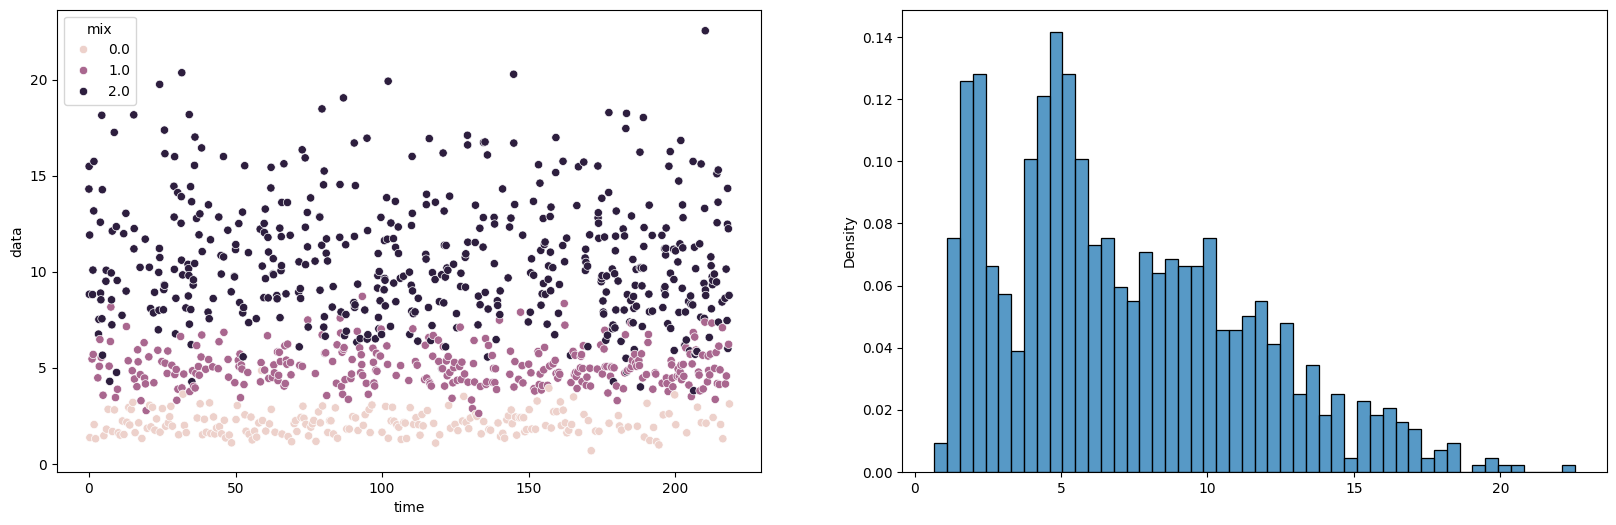

In [95]:
# Simulating some data from the log normal mixture distribution

weights = [0.2, 0.3, 0.5]
mus = [np.log(2), np.log(5), np.log(10)]
sigmas = [0.3, 0.2, 0.3]

n = 1_000
data = np.zeros(n)
mix = np.zeros(n)
time = np.zeros(n + 1)
for i in range(n):
    j = np.random.choice([0, 1, 2], p=weights)
    data[i] = np.random.lognormal(mus[j], sigmas[j])
    mix[i] = j
    time[i + 1] = time[i] + 1 / data[i]

df = pd.DataFrame({'data': data, 'mix': mix, 'time': time[:-1]})


fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.scatterplot(x='time', y='data', hue='mix', data=df, ax=axs[0])
sns.histplot(data, bins=50, ax=axs[1], stat='density')
plt.show()




***K-means initialization***

Eventually we will want to fit this model to some data using the EM algorithm, but first we will use K-means clustering to initialize the model paramters.

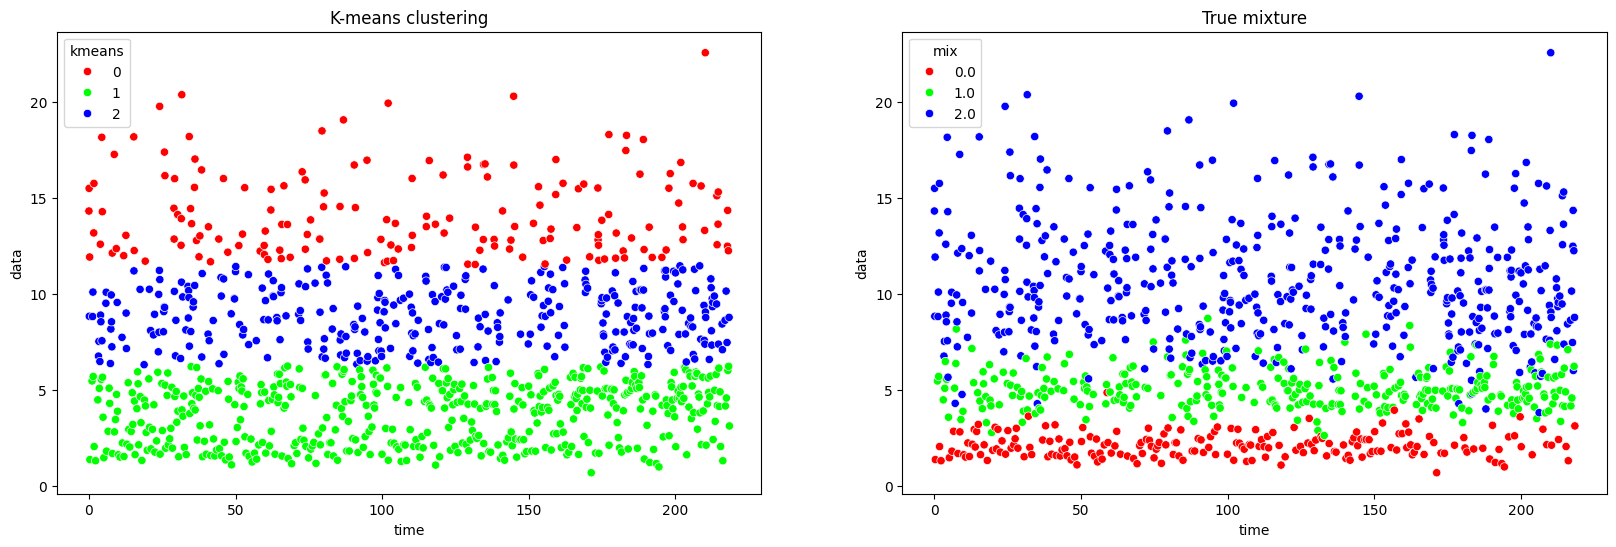

In [96]:
def k_means(X, k, max_iter = 1_000):
   
    centroids = np.random.choice(X, k, replace=False)
    clusters = np.zeros((X.shape[0], k))

    for _ in range(max_iter):

        distances = np.abs(X[:, None] - centroids)
        clusters = np.argmin(distances, axis=1)
        centroids = np.array([X[clusters == i].mean() for i in range(k)])

    return centroids, clusters

centroids, clusters = k_means(data, 3)

# reordering the clusters
order = np.argsort(centroids)
clusters = np.array([order[i] for i in clusters])


df['kmeans'] = clusters

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.scatterplot(x='time', y='data', hue='kmeans', data=df, palette= [(1,0,0), (0,1,0), (0,0,1)], ax=axs[0])
axs[0].set_title('K-means clustering')
sns.scatterplot(x = 'time', y = 'data', hue = 'mix', data = df, palette= [(1,0,0), (0,1,0), (0,0,1)], ax = axs[1])
axs[1].set_title('True mixture')
plt.show()

***EM Algorithm***

Now we turn to the EM algorithm to fit the model to our data. To do this, we introduce an explicit latent variable $\bold{z}$ which contains information about which log-normal a given data point may have been generated by.

Let $\bold{z}$ be a $K$-dimensional binary random variable having a 1-of-$K$ representation. We define the joint distribution $p(X, \bold{z})$ in terms of the marginal distribution $p(\bold{z})$ and the condition distributions $p(X | \bold{z})$. The marginal distribution over $\bold{z}$ is specified by the mixing coefficients $\pi_k$ such that $p(\bold{z}_k = 1) = \pi_k$. Becaue $\bold{z}$ uses a binary 1-of-$K$ representation we can write,

$$
\begin{equation*}
p(\bold{z}) = \prod_{k = 1}^{K} \pi_k^{\bold{z}_k}
\end{equation*}
$$


Similarly, the conditional distribution of $X$ given a particular value for $\bold{z}$ is a log normal

$$
\begin{equation*}
p(X | \bold{z}_k = 1) = \phi(x; \mu_k, \sigma_k) 
\end{equation*}
$$

and again using the fact that $\bold{z}$ has a 1-of-$K$ representation we get
$$
\begin{equation*}
p(X | \bold{z})\prod_{k = 1}^{K} \phi(x; \mu_k, \sigma_k)^{\bold{z}_k}
\end{equation*}
$$

Finally, we can find the marginal distribution of $X$ by summing the joint distributions over all possible states of $\bold{z}$ to give,

$$
\begin{align*}
p(X) = \sum_{\bold{z}}p(\bold{z})p(X|\bold{z}) &= \sum_{\bold{z}}\prod_{k = 1}^{K} \pi_k^{\bold{z}_k}\prod_{k = 1}^{K} \phi(x; \mu_k, \sigma_k)^{\bold{z}_k} \\

&= \sum_{k = 1}^{K}\pi_k\phi(x; \mu_k, \sigma_k)
\end{align*}
$$

Based on our construction where we represent the marginal distribution of $X$ as the sum of joint distributions including our latent variable $\bold{z}$, it follows that for every observed data point $X_n$ there is a corresponding latent variable $\bold{z}_n$. 

Importantly, we want to know the probability that a given data point was drawn from a particular log-normal. To find this value, we will use $\gamma(\bold{z}_k)$ to denote $p(\bold{z}_k = 1 | X)$. Using Baye's rule we have,


$$
\begin{align*}
\gamma(\bold{z}_k) := p(\bold{z}_k = 1 | X) &= \frac{p(X | \bold{z}_k = 1)p(\bold{z}_k = 1 )}{p(X)} \\ 
&= \frac{\pi_k\phi(X ; \mathbb{\mu}_k, \mathbb{\sigma}_k)}{\sum_{j = 1}^{K}\pi_k\phi(X; \mathbb{\mu}_j, \mathbb{\sigma}_j)}
\end{align*}
$$

Now, in hopes of finding the parameters which maximize the likelihood function of our model given the data, we will view $\pi_k$ is the prior probability of $\bold{z}_n = 1$ , and the quantity $\gamma(\bold{z}_k)$ as the corresponding posterior probability once we have observed $X$. We can represent the value of  $\gamma(\bold{z}_k)$ uisng a scatterplot where the amount of color (RGB) is proportional to the element of $\gamma(\bold{z}_k)$.

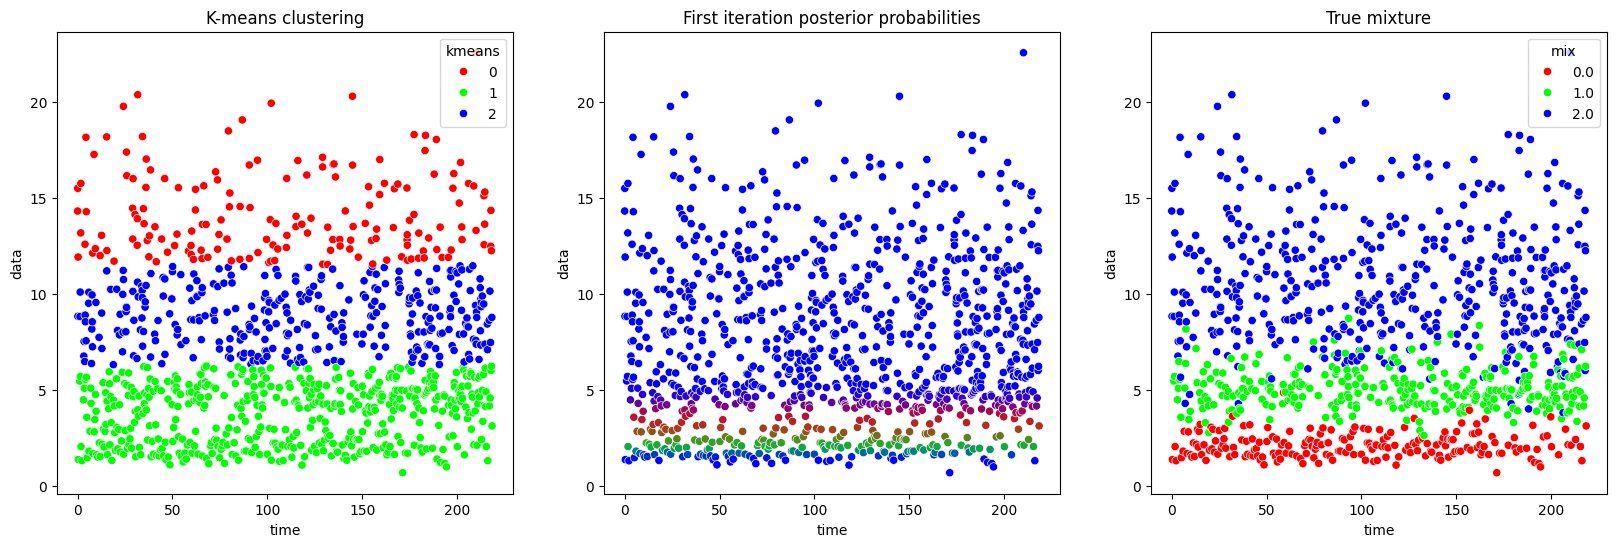

In [116]:
def find_gamma(X, pi, mu, sigma):
    N = X.shape[0]
    K = len(pi)
    gamma = np.zeros((N, K))

    for n in range(N):
        denominator = sum([pi[j] * lognorm.pdf(X[n], s=sigma[j], scale=mu[j]) for j in range(K)])
        for k in range(K):
            numerator = pi[k] * lognorm.pdf(X[n], s=sigma[k], scale=mu[k]) 
            gamma[n, k] = numerator / denominator

    return gamma


# getting the mean and standard deviation for each cluster and transforming them to the parameters of the log normal distribution
mu = df.groupby('kmeans')['data'].mean().values
sigma = df.groupby('kmeans')['data'].std().values
mu_transformed = np.log(mu)
sigma_transformed = np.sqrt(np.log(1 + (sigma / mu) ** 2))

# getting the proportion of each cluster
pi = df['kmeans'].value_counts(normalize=True).sort_index().values



# getting the gamma values
gamma = find_gamma(df['data'].values, pi, mu_transformed, sigma_transformed)



# adding the gamma values to the dataframe
df[['gamma_0', 'gamma_1', 'gamma_2']] = gamma

# Apply the color function to each row
def gamma_to_rgb(row, order):

    return (row[f'gamma_{order[2]}'], row[f'gamma_{order[1]}'], row[f'gamma_{order[0]}'])

df['color'] = df.apply(lambda row: gamma_to_rgb(row, order), axis=1)



# Plot the data
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.scatterplot(x='time', y='data', hue='kmeans', data=df, palette= [(1,0,0), (0,1,0), (0,0,1)], ax=axs[0])
axs[0].set_title('K-means clustering')
sns.scatterplot(x='time', y='data', color=df['color'], data=df, legend=False, ax=axs[1])
axs[1].set_title('First iteration posterior probabilities')
sns.scatterplot(x = 'time', y = 'data', hue = 'mix', data = df, palette= [(1,0,0), (0,1,0), (0,0,1)],  ax = axs[2])
axs[2].set_title('True mixture')
plt.show()


***Maximum Likelihood***

Now we turn to maximizing the likelihood function for our model given our data. We will see that the posterior probabilties $\gamma(\bold{z}_k)$ will be essential for our iteritive solution. We can represent our data set as an  $N \times 1$ matrix $\bold{X}$ and our parameters by $K$ dimensional vectors $\bold{\pi}$, $\bold{\mu}$ and $\bold{\sigma}$ . Thus, likelihood function we wish to maximize is given by,

$$
\begin{align*}
l(\bold{X}) = \text{ln} \ p(\bold{X}|\bold{\pi}, \bold{\mu}, \bold{\sigma}) &= \text{ln} \ \prod_{n = 1}^{N} \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k) \\
&= \sum_{n = 1}^{N} \ \text{ln} \ \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k) 
\end{align*}
$$

Now for optimization we set the derivitives equal to zero. First, with respect to the means $\bold{\mu_j}$ we have,

$$
\begin{align*}
0 = \frac{\partial l(\bold{X})}{\partial \mu_{j}} &= \frac{\partial}{\partial \mu_{j}} \sum_{n = 1}^{N} \ \text{ln} \ \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k) \\

&= \sum_{n = 1}^{N} \ \frac{\partial}{\partial \mu_{j}} \ \text{ln} \ \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k) \\

&= \sum_{n = 1}^{N} \ \frac{1}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k)} \cdot \frac{\partial \ \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k)}{\partial \mu_{j}} \\ \\

\text{Recalling that each log-normal is given by $\phi(x; \mu_k, \sigma_k) = \frac{1}{\sqrt{2\pi}\sigma_k}e^{\frac{-(x - \mu_k)^2}{2\sigma_k^2}}$} \\

&= \sum_{n = 1}^{N} \ \frac{\pi_j\phi(\bold{x}_n|\bold{\mu}_j, \bold{\sigma}_j)}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k)} \cdot \frac{\partial \frac{-(\text{ln}(x) - \mu_j)^2}{2\sigma^2}}{\partial \mu_j} \\


&= \sum_{n = 1}^{N} \ \frac{\pi_j\phi(\bold{x}_n|\bold{\mu}_j, \bold{\sigma}_j)}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k)} \cdot \frac{\text{ln}(x) - \mu_j}{\sigma^2} \\ \\

\text{Notice the appearance of our posterior probability $\gamma(\bold{z}_{n, k}) =  \frac{\pi_j\phi(\bold{x}_n|\bold{\mu}_j, \bold{\sigma}_j)}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k)}$} \\ \\

&= \sum_{n = 1}^{N} \ \gamma(\bold{z}_{n, k}) \cdot \frac{\text{ln}(\bold{x}_n) - \mu_j}{\sigma^2} \\ \\

\text{multiplying by $\sigma^2$ and rearanging we get} \\

\mu_j &= \frac{1}{N_k}\sum_{n = 1}^{N} \gamma(\bold{z}_{n, k})\text{ln}(\bold{x}_{n, k}) \\ \\

\text{where $N_k = \sum_{n = 1}^{N}\gamma(\bold{z}_{n, k}$)}


\end{align*}
$$


Similarly, we can optimize with respect to $\bold{\sigma_j}$

$$
\begin{align*}
\sigma_j = \frac{1}{N_k} \ \sum_{n = 1}^{N}\gamma(\bold{z}_{n, k})(\text{ln}(\bold{x}_n) - \mu_j)^2
\end{align*}
$$


Finally with respect to $\bold{\pi_j}$ we make use of a Lagrange multiplier $\lambda$ to enforce the constraint that the weights sum to one.

$$
\begin{align*}
0 = \frac{\partial l(\bold{X})}{\partial \pi_{j}} &= \frac{\partial}{\partial \pi_{j}} \sum_{n = 1}^{N} \ \text{ln} \ \sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n|\bold{\mu}_k, \bold{\sigma}_k) + \lambda(\sum_{k = 1}^{K}\pi_k - 1)\\

0 &= \sum_{n = 1}^{N}\frac{\phi(\bold{x}_n|\mu_j, \sigma_j)}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n| \mu_k, \mu_k)} + \lambda \\

\sum_{k = 1}^{K}\pi_k \cdot 0 &= \sum_{k = 1}^{K}\pi_k  (\sum_{n = 1}^{N}\frac{\phi(\bold{x}_n|\mu_j, \sigma_j)}{\sum_{k = 1}^{K}\pi_k\phi(\bold{x}_n| \mu_k, \mu_k)} + \lambda)


\end{align*}
$$


Estimated pi: [0.168 0.506 0.326], True pi: [0.2, 0.3, 0.5]
Estimated mu: [14.17899498  3.75782591  8.80644173], True mu: [0.6931471805599453, 1.6094379124341003, 2.302585092994046]
Estimated sigma: [2.20919056 1.51874186 1.46669882], True sigma: [0.3, 0.2, 0.3]


C:\Users\smearlab\AppData\Local\Temp\ipykernel_4140\301498352.py:51: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x='time', y='data', hue='clusters', data=df, palette= [(1,0,0), (0,1,0), (0,0,1)], ax=axs[0])


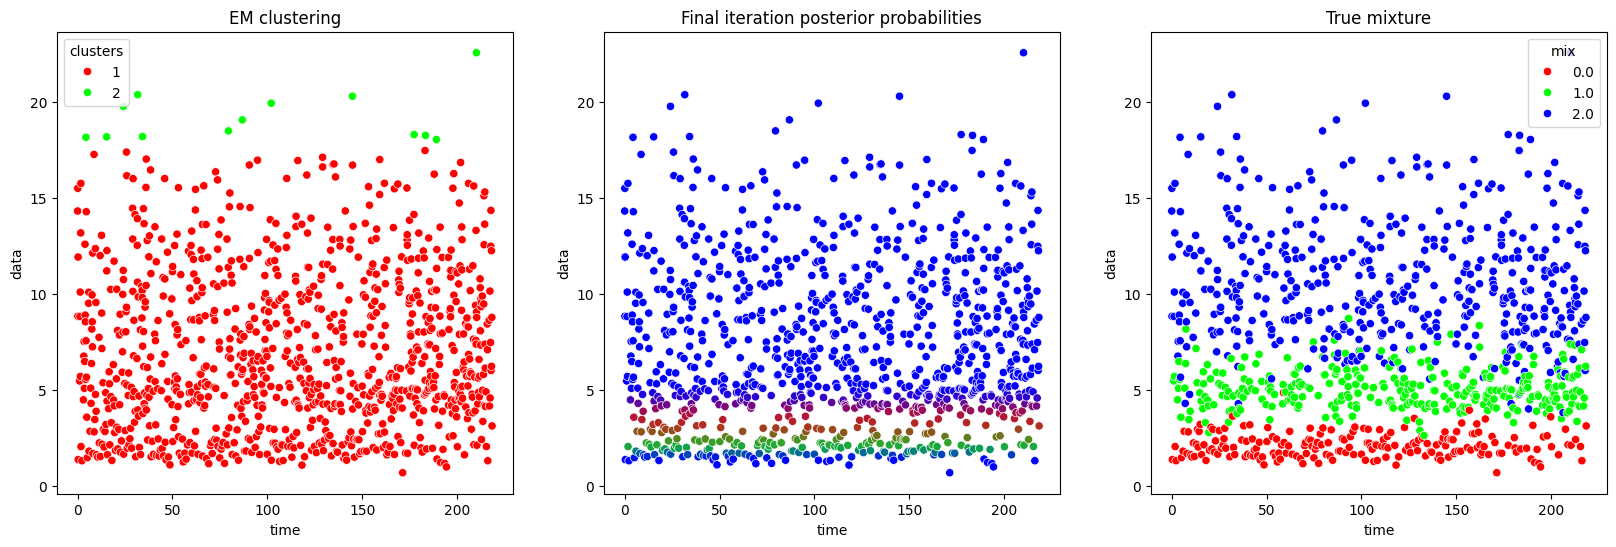

In [117]:
def EM_algorithm(X, pi, mu, sigma, max_iter):

    likelihoods = []

    N = X.shape[0]
    K = len(pi)

    for _ in range(max_iter):


        # E-step
        gamma = find_gamma(X, pi, mu, sigma)

        # M-step
        for j in range(K):
            pi[j] = np.mean(gamma[:, j])
            mu[j] = np.sum(gamma[:, j] * np.log(X)) / np.sum(gamma[:, j])
            sigma[j] = np.sqrt(np.sum(gamma[:, j] * (np.log(X) - mu[j]) ** 2) / np.sum(gamma[:, j]))

        likelihood = np.sum([np.log(np.sum([pi[j] * lognorm.pdf(X[i], s=sigma[j], scale=(mu[j])) for j in range(K)])) for i in range(N)])
        print(likelihood)
        likelihoods.append(likelihood)

    return pi, mu, sigma, likelihoods

# getting the mean and standard deviation for each cluster and transforming them to the parameters of the log normal distribution
pi = df['kmeans'].value_counts(normalize=True).sort_index().values
mu = df.groupby('kmeans')['data'].mean().values
sigma = df.groupby('kmeans')['data'].std().values
mu_transformed = np.log(mu)
sigma_transformed = np.sqrt(np.log(1 + (sigma / mu) ** 2))

pi_final, mu_final, sigma_final, likelihoods_final = EM_algorithm(df['data'].values, pi, mu, sigma, 0)

print(f'Estimated pi: {pi}, True pi: {weights}')
print(f'Estimated mu: {mu}, True mu: {mus}')
print(f'Estimated sigma: {sigma}, True sigma: {sigmas}')


# assigning the clusters to the data
gamma = find_gamma(df['data'].values, pi_final, mu_final, sigma_final)
clusters = np.argmax(gamma, axis=1)
df['clusters'] = clusters

# getting the order of the clusters
order = np.argsort(mu_final)
df['color'] = df.apply(lambda row: gamma_to_rgb(row, order), axis=1)

# Plot the data
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.scatterplot(x='time', y='data', hue='clusters', data=df, palette= [(1,0,0), (0,1,0), (0,0,1)], ax=axs[0])
axs[0].set_title('EM clustering')
sns.scatterplot(x='time', y='data', color=df['color'], data=df, legend=False, ax=axs[1])
axs[1].set_title('Final iteration posterior probabilities')
sns.scatterplot(x = 'time', y = 'data', hue = 'mix', data = df, palette= [(1,0,0), (0,1,0), (0,0,1)],  ax = axs[2])
axs[2].set_title('True mixture')
plt.show()



